# **Data load & preprocess**

The data was obtained from the following site: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

 There are two different typs of photos: "NORMAL" and "PNEUMONIA"

 "NORMAL", are the normal X-ray images of the chest without pneumonia
 
 "PNEUMONIA", are X-ray images of the chest with the pneumonia disease

### **_IMPORTS_**

In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random

from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from PIL import Image

#### **_Checking label distribution_**

In [89]:
data_dir = "../data/chest_xray/"
sets = ['train', 'val', 'test']

for dataset in sets:
    normal_count = len(os.listdir(os.path.join(data_dir, dataset, "NORMAL")))
    pneumonia_count = len(os.listdir(os.path.join(data_dir, dataset, "PNEUMONIA")))
    
    print(f"\n📂 {dataset.upper()} SET")
    print(f"NORMAL: {normal_count} images")
    print(f"PNEUMONIA: {pneumonia_count} images")



📂 TRAIN SET
NORMAL: 1341 images
PNEUMONIA: 3875 images

📂 VAL SET
NORMAL: 8 images
PNEUMONIA: 8 images

📂 TEST SET
NORMAL: 234 images
PNEUMONIA: 390 images


Looks like the data is imbalanced, because there are more PNEUMONIA images then NORMAL images!

### **_train_data balance_**

In [90]:
source_dir = "../data/chest_xray/train/NORMAL"
target_dir = "../data/chest_xray/train/NORMAL_augmented"

# Data Augmentation Pipeline
augment_transform = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.2, contrast=0.2)], p=0.3)
])

In [ ]:
normal_images = os.listdir(source_dir)

# Saving of new changed data
for img_name in normal_images:
    img_path = os.path.join(source_dir, img_name)
    image = Image.open(img_path).convert("RGB")

    for i in range(2):  # About 2 times each image should be used to get a similar number as pneumonia
        augmented_image = augment_transform(image)
        save_path = os.path.join(target_dir, f"{img_name.split('.')[0]}_aug{i}.jpg")
        augmented_image.save(save_path)

# random deletion of unnecessary images, so that the number of both is 3875
all_files = os.listdir(target_dir)
num_to_delete = 148
files_to_delete = random.sample(all_files, num_to_delete)

for file in files_to_delete:
    file_path = os.path.join(target_dir, file)
    os.remove(file_path)

print(f"✅ {len(os.listdir(target_dir))} augmented NORMAL images created.")

✅ 2534 augmentierte NORMAL-Bilder erstellt.


In [ ]:
dataset = "train"

normal_count = len(os.listdir(os.path.join(data_dir, dataset, "NORMAL"))) + \
               len(os.listdir(os.path.join(data_dir, dataset, "NORMAL_AUGMENTED")))

pneumonia_count = len(os.listdir(os.path.join(data_dir, dataset, "PNEUMONIA")))

print(f"\n📂 {dataset.upper()} SET")
print(f"NORMAL: {normal_count} images")
print(f"PNEUMONIA: {pneumonia_count} images")



📂 TRAIN SET
NORMAL: 3875 images
PNEUMONIA: 3875 images


now the training data is balanced!

### **_GET DATA_**

### _Image pre-processing_

In [94]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # I would use the model "ResNet", which expects 224x224 images.
    transforms.ToTensor(), # the images are converted to Pytroch-tensor 
    transforms.Normalize([0.5], [0.5])  # normalisation
])

### _Load Datasets_


we now have to classify each picture whether it corresponds to "NORMAL" or "PNEUMONIA"

0 = "NORMAL", 1 = "PNEUMONIA"

In [95]:
train_dataset = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=transform)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, "val"), transform=transform)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=transform)

In [96]:
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [100]:
print(train_dataset.class_to_idx)


{'NORMAL': 0, 'NORMAL_augmented': 1, 'PNEUMONIA': 2}


this is false, because NORMAL_augmented should have also the number 0!

In [103]:
data_dir = "../data/chest_xray/train"

train_dataset = datasets.ImageFolder(data_dir)

# Manual reassignment of the labels
train_dataset.class_to_idx = {'NORMAL': 0, 'NORMAL_augmented': 0, 'PNEUMONIA': 1}

# for all pictures:
for i in range(len(train_dataset)):
    img, label = train_dataset.samples[i]
    if "NORMAL_augmented" in img:
        train_dataset.samples[i] = (img, 0)  # set label to 0

print(train_dataset.class_to_idx)


{'NORMAL': 0, 'NORMAL_augmented': 0, 'PNEUMONIA': 1}






### **_VISUALIZATIONS_**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.94509804].


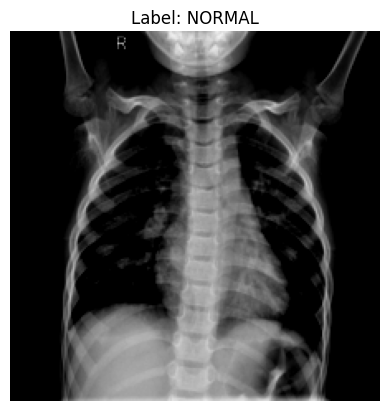

In [97]:
# first picture in train_dataset
image, label = train_dataset[0] 

# Change order (C, H, W → H, W, C)
image = image.permute(1, 2, 0).numpy()



plt.imshow(image)
plt.title("Label: NORMAL" if label == 0 else "Label: PNEUMONIA")
plt.axis('off')
plt.show()